In [1]:
!nvidia-smi

Thu Jul 21 10:29:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Хакатоны/RZD/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/19HepTUHNd167HQL72m3aOz7-bOtAqLA_/RZD


In [ ]:
# for augmentations
!pip install albumentations==1.1.0

# for pretrained segmentation models for PyTorch
!pip install segmentation-models-pytorch

!pip install opencv-python==4.5.5.62

In [4]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torchvision import transforms as T

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as albu
from glob import glob
from sklearn.model_selection import train_test_split

from google.colab.patches import cv2_imshow
from tqdm import tqdm
from PIL import Image

# Чтение и анализ данных

In [5]:
train_image_path = "train/images/"
train_mask_path = "train/mask/"

ALL_IMAGES = glob("train/images/" + '*' + '.png')
ALL_MASKS = ["train/mask/" + i.split("/")[-1] for i in ALL_IMAGES]

len(ALL_IMAGES), len(ALL_MASKS)

(8203, 8203)

Посмотрим на пример исходного изображения:

(1512, 2688, 3)


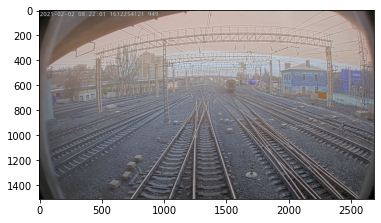

In [ ]:
image = cv2.imread(ALL_IMAGES[1000])
print(image.shape)
plt.imshow(image)
plt.show()

Посмотрим на его маску:

[ 0  6  7 10]
(1512, 2688, 3)


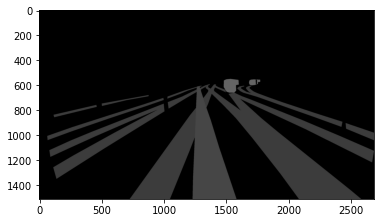

In [ ]:
mask = cv2.imread(ALL_MASKS[1000])
print(np.unique(mask))
print(mask.shape)
plt.imshow(mask*10)
plt.show()

Посмотрим на разрешения и значения пикселей нескольких масок:

In [ ]:
for i, mask in enumerate(ALL_MASKS[:10]):
  mask = cv2.imread(mask)
  print('Маска:', i, ',', 'разрешение:', mask.shape, ',', 'пиксели:', np.unique(mask))

Маска: 0 , разрешение: (1512, 2688, 3) , пиксели: [ 0  6  7 10]
Маска: 1 , разрешение: (1512, 2688, 3) , пиксели: [ 0  7 10]
Маска: 2 , разрешение: (1512, 2688, 3) , пиксели: [0 6 7]
Маска: 3 , разрешение: (1512, 2688, 3) , пиксели: [0 6 7]
Маска: 4 , разрешение: (1512, 2688, 3) , пиксели: [0 6 7]
Маска: 5 , разрешение: (1512, 2688, 3) , пиксели: [0 6 7]
Маска: 6 , разрешение: (1080, 1920, 3) , пиксели: [0 7]
Маска: 7 , разрешение: (1512, 2688, 3) , пиксели: [0 6 7]
Маска: 8 , разрешение: (1512, 2688, 3) , пиксели: [0 7]
Маска: 9 , разрешение: (1080, 1920, 3) , пиксели: [0 6 7]


Основные выводы:
*   изображения и маски даны в очень высоком разрешении(1512x2688, 1080x1920)
*   маска может включать в себя до 4 классов пикселей(0, 6, 7, 10)





# Подготовка данных для обучения

Основные преобразования данных:
- Переопределение пикселей(от 0 до 4)
- Аугметация 
  - Ресайз к 832х1472
  - Горизонтальный флип
  - Изменения яркости
- Нормализация

In [6]:
class Dataset(BaseDataset):
    def __init__(self, images_dir, masks_dir, augmentation=None):
        self.images_fps = images_dir
        self.masks_fps = masks_dir
        self.augmentation = augmentation
    
    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        mask[mask == 6] = 1
        mask[mask == 7] = 2
        mask[mask == 10] = 3

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        t = T.Compose([T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], 
                                                 std=[0.229, 0.224, 0.225])])
        image = t(image)

        mask = torch.from_numpy(mask)
        mask = mask.long().unsqueeze(0)
            
        return image, mask

    def __len__(self):
        return len(self.images_fps)

In [7]:
def get_training_augmentation():
    train_transform = [
        albu.Resize(height=832, width=1472, interpolation=cv2.INTER_NEAREST),
        albu.HorizontalFlip(p=0.5),
        albu.RandomBrightnessContrast(p=0.2),

    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(height=832, width=1472, interpolation=cv2.INTER_NEAREST),
    ]
    return albu.Compose(test_transform)

Разделяем выборку на тренировочное и валидационное множество и отправляем все в torch dataloaders:

In [8]:
image_train, image_val, label_train, label_val = train_test_split(ALL_IMAGES, ALL_MASKS, test_size=0.05, random_state=42)

len(image_train), len(image_val)

(7792, 411)

In [ ]:
train_dataset = Dataset(
    image_train, 
    label_train, 
    augmentation=get_training_augmentation(),
)

valid_dataset = Dataset(
    image_val, 
    label_val, 
    augmentation=get_validation_augmentation(), 
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=4)

In [ ]:
image, label = next(iter(valid_loader))
print(f"Feature batch shape: {image.shape}")
print(f"Labels batch shape: {label.shape}")

Feature batch shape: torch.Size([2, 3, 832, 1472])
Labels batch shape: torch.Size([2, 1, 832, 1472])


# Финальная модель

В качестве итоговой модели используется **FPN** c энкодером **efficientnet-b3**(инициализируем веса, полученные в ходе обучения на датасете Imagenet):

In [13]:
ENCODER = 'efficientnet-b3' #'efficientnet-b3', 'mobilenet_v2'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = None # sigmoid, None, softmax2d
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = smp.FPN(encoder_name=ENCODER, 
                encoder_weights=ENCODER_WEIGHTS, 
                in_channels=3,
                classes=4, 
                activation=ACTIVATION
                )

В качестве функции потерь используется DiceLoss (наиболее популярный и близкий по смыслу к метрике IOU):

In [ ]:
loss = smp.losses.DiceLoss(mode='multiclass')

Функция для расчета метрики mIOU:

In [ ]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=4):
    with torch.no_grad():
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): 
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: 
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)

        return np.nanmean(iou_per_class)

Функция для обучения модели:

In [ ]:
def fit(model, train_loader, val_loader, criterion, optimizer, model_path, epochs=20):
    '''
    model - обучаемая модель
    train_loader - тренировочные данные
    val_loader - валидационные данные
    criterion - функция потерь
    optimizer - оптимизатор для обучения
    model_path - название сохраняемой модели
    '''
    min_loss = 100
    model.to(device)

    for e in range(epochs):
        epoch_train_loss, epoch_val_loss, epoch_train_iou, epoch_val_iou = 0, 0, 0, 0
        model.train()

        for image, mask in tqdm(train_loader):
            image, mask = image.to(device), mask.to(device)
            optimizer.zero_grad() #reset gradient

            #forward
            output = model(image)
            loss = criterion(output, mask)

            # backward
            loss.backward()
            optimizer.step() #update weight          
            
            # calc loss and metric
            epoch_train_loss += loss.item()
            epoch_train_iou += mIoU(output, mask)
            
          
        model.eval()
        with torch.no_grad():
            for image, mask in tqdm(val_loader):
                image, mask = image.to(device), mask.to(device)
                output = model(image)

                loss = criterion(output, mask)  

                epoch_val_loss += loss.item()
                epoch_val_iou +=  mIoU(output, mask)
  

        #calc mean for each batch
        train_loss = epoch_train_loss / len(train_loader)
        val_loss = epoch_val_loss / len(val_loader)
        train_iou = epoch_train_iou / len(train_loader)
        val_iou = epoch_val_iou / len(val_loader)

        print("Epoch:{}/{}..".format(e+1, epochs),
              "Train Loss: ", train_loss,
              "Val Loss: ", val_loss,
              "Train mIoU:", train_iou, 
              "Val mIoU: ", val_iou)

        # save model
        if min_loss > val_loss:
            min_loss = val_loss
            torch.save(model, model_path)
            print('Model saved!')

Запустим первое обучение. Будем смотреть результаты на валидационном множестве + далее на тестовом множестве из публичного лидерборда для того, чтобы избежать переобучения(все ошибки в коде ниже связаны с досрочным прерыванием обучения):

In [ ]:
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

fit(model, train_loader, valid_loader, 
    loss, optimizer,'FPN_effnet3_832x1472.pth')

100%|██████████| 206/206 [00:32<00:00,  6.25it/s]


Epoch:1/20.. Train Loss:  0.16879180641328528 Val Loss:  0.13578390619419153 Train mIoU: 0.7466697393361037 Val mIoU:  0.7890076258619099
Model saved!


100%|██████████| 206/206 [00:33<00:00,  6.21it/s]


Epoch:2/20.. Train Loss:  0.12254113275213531 Val Loss:  0.11204806418673506 Train mIoU: 0.8066807337329627 Val mIoU:  0.8234133113852589
Model saved!


100%|██████████| 206/206 [00:33<00:00,  6.21it/s]


Epoch:3/20.. Train Loss:  0.10869758739470824 Val Loss:  0.11067100216462775 Train mIoU: 0.8244273461597176 Val mIoU:  0.8244279871738026
Model saved!


100%|██████████| 206/206 [00:34<00:00,  6.05it/s]


Epoch:4/20.. Train Loss:  0.10203649094079677 Val Loss:  0.09624667422285357 Train mIoU: 0.8332531828690385 Val mIoU:  0.8407638375313229
Model saved!


100%|██████████| 206/206 [00:33<00:00,  6.17it/s]


Epoch:5/20.. Train Loss:  0.0984123474335034 Val Loss:  0.1001755485980256 Train mIoU: 0.8385081051790023 Val mIoU:  0.8373852428499788


  1%|          | 39/3896 [00:18<31:02,  2.07it/s]


KeyboardInterrupt: ignored

Далее будем постепенно дообучать нашу модель. Для этого необходимо загрузить предыдущую модель и переопределить имя сохраняемой модели. Также постепенно уменьшаем шаг обучения. Ниже приведены некоторые сохранившиеся логи:

In [ ]:
# load best saved checkpoint
model = torch.load('FPN_effnet3_832x1472.pth')

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00005),
])

fit(model, train_loader, valid_loader, 
    loss, optimizer, 'FPN_effnet3_832x1472_2.pth')

100%|██████████| 206/206 [00:33<00:00,  6.09it/s]


Epoch:1/20.. Train Loss:  0.07703800441303292 Val Loss:  0.08858256758127397 Train mIoU: 0.8678571447346162 Val mIoU:  0.8536140424779579
Model saved!


100%|██████████| 206/206 [00:33<00:00,  6.08it/s]


Epoch:2/20.. Train Loss:  0.07542335177012538 Val Loss:  0.08713863312619403 Train mIoU: 0.8699564443824024 Val mIoU:  0.8558167377547078
Model saved!


100%|██████████| 206/206 [00:33<00:00,  6.13it/s]


Epoch:3/20.. Train Loss:  0.07288612262776133 Val Loss:  0.08421572196541481 Train mIoU: 0.8734789924675065 Val mIoU:  0.8600818697496492
Model saved!


100%|██████████| 206/206 [00:33<00:00,  6.15it/s]


Epoch:4/20.. Train Loss:  0.0707134314615746 Val Loss:  0.0812888023199387 Train mIoU: 0.8761360355118524 Val mIoU:  0.8622429932783026
Model saved!


100%|██████████| 206/206 [00:33<00:00,  6.20it/s]


Epoch:5/20.. Train Loss:  0.06980060129302115 Val Loss:  0.08019560582718803 Train mIoU: 0.8779917920141336 Val mIoU:  0.8651621350700791
Model saved!


100%|██████████| 206/206 [00:33<00:00,  6.13it/s]


Epoch:6/20.. Train Loss:  0.06862540001879605 Val Loss:  0.07829182602248146 Train mIoU: 0.8797695472014583 Val mIoU:  0.8681573122574405
Model saved!


100%|██████████| 206/206 [00:33<00:00,  6.09it/s]


Epoch:7/20.. Train Loss:  0.06677689232712408 Val Loss:  0.08131767143902269 Train mIoU: 0.8821278580268141 Val mIoU:  0.8645575204638153


100%|██████████| 206/206 [00:33<00:00,  6.19it/s]


Epoch:8/20.. Train Loss:  0.06615262664472053 Val Loss:  0.07836415184643662 Train mIoU: 0.8833396800272664 Val mIoU:  0.8681144748013709


  4%|▍         | 173/3896 [01:21<29:12,  2.12it/s]


KeyboardInterrupt: ignored

Ниже мы видим рост метрик на валидационном множестве, но при запуске предсказания этой модели на публичном тесте(следующий раздел в блокноте) результаты постепенно начинают падать, что говорит о начале переобучения(поэтому оставляем предыдущую модель):

In [ ]:
model = torch.load('FPN_effnet3_832x1472_4.pth')

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00003),
])

fit(model, train_loader, valid_loader, 
    loss, optimizer, 'FPN_effnet3_832x1472_6.pth')

100%|██████████| 206/206 [02:51<00:00,  1.20it/s]


Epoch:1/20.. Train Loss:  0.0637527796453213 Val Loss:  0.07874385542371898 Train mIoU: 0.8866061540965932 Val mIoU:  0.8684118235559369
Model saved!


100%|██████████| 206/206 [00:36<00:00,  5.70it/s]


Epoch:2/20.. Train Loss:  0.061586368305023446 Val Loss:  0.07974434680151708 Train mIoU: 0.8895084251049713 Val mIoU:  0.8680292897308952


100%|██████████| 206/206 [00:36<00:00,  5.66it/s]


Epoch:3/20.. Train Loss:  0.06073927289942085 Val Loss:  0.07680979096195073 Train mIoU: 0.8910061805359777 Val mIoU:  0.8700612891965323
Model saved!


100%|██████████| 206/206 [00:36<00:00,  5.68it/s]


Epoch:4/20.. Train Loss:  0.06061771691029077 Val Loss:  0.07454691704326463 Train mIoU: 0.891346103482992 Val mIoU:  0.873428209690343
Model saved!


100%|██████████| 206/206 [00:36<00:00,  5.68it/s]


Epoch:5/20.. Train Loss:  0.059046605643978844 Val Loss:  0.07603202557679518 Train mIoU: 0.8935029254897171 Val mIoU:  0.8709383188721433


100%|██████████| 206/206 [00:37<00:00,  5.55it/s]


Epoch:6/20.. Train Loss:  0.057872499008443073 Val Loss:  0.07413640466419238 Train mIoU: 0.8950704771362279 Val mIoU:  0.8741806671789563
Model saved!


100%|██████████| 206/206 [00:36<00:00,  5.66it/s]


Epoch:7/20.. Train Loss:  0.05671094221806869 Val Loss:  0.07359319715534599 Train mIoU: 0.8966476828961233 Val mIoU:  0.87394340893381
Model saved!


100%|██████████| 206/206 [00:37<00:00,  5.55it/s]


Epoch:8/20.. Train Loss:  0.05633516203864521 Val Loss:  0.07433733481515958 Train mIoU: 0.8974699423259477 Val mIoU:  0.8732221246834723


100%|██████████| 206/206 [00:36<00:00,  5.70it/s]


Epoch:9/20.. Train Loss:  0.05613629537533196 Val Loss:  0.07488183865269411 Train mIoU: 0.8980186569376236 Val mIoU:  0.8735027661683743


100%|██████████| 206/206 [00:36<00:00,  5.61it/s]


Epoch:10/20.. Train Loss:  0.05575431704337592 Val Loss:  0.07385016789714109 Train mIoU: 0.8985409702047017 Val mIoU:  0.8743043103198033


100%|██████████| 206/206 [00:36<00:00,  5.64it/s]


Epoch:11/20.. Train Loss:  0.05413064214131304 Val Loss:  0.07350718034702597 Train mIoU: 0.9008946854911027 Val mIoU:  0.8764059524981199
Model saved!


100%|██████████| 206/206 [00:36<00:00,  5.65it/s]


Epoch:12/20.. Train Loss:  0.054689555373463546 Val Loss:  0.07377285546469457 Train mIoU: 0.900637502801081 Val mIoU:  0.8758524936824954


100%|██████████| 206/206 [00:37<00:00,  5.52it/s]


Epoch:13/20.. Train Loss:  0.05299500109784657 Val Loss:  0.07314762060792701 Train mIoU: 0.9025196685653388 Val mIoU:  0.8761899524164521
Model saved!


100%|██████████| 206/206 [00:36<00:00,  5.64it/s]


Epoch:14/20.. Train Loss:  0.05320771642457656 Val Loss:  0.07204492845870916 Train mIoU: 0.9029631447455252 Val mIoU:  0.8768940764958285
Model saved!


100%|██████████| 206/206 [00:36<00:00,  5.64it/s]


Epoch:15/20.. Train Loss:  0.0528755935226439 Val Loss:  0.07194241772866944 Train mIoU: 0.9032970691586285 Val mIoU:  0.8773972502311634
Model saved!


100%|██████████| 206/206 [00:37<00:00,  5.53it/s]


Epoch:16/20.. Train Loss:  0.05233940315763686 Val Loss:  0.07015986812924876 Train mIoU: 0.9040976726146638 Val mIoU:  0.8798746535989311
Model saved!


100%|██████████| 206/206 [00:36<00:00,  5.62it/s]


Epoch:17/20.. Train Loss:  0.05158324368313353 Val Loss:  0.06977937254801538 Train mIoU: 0.9054515304754663 Val mIoU:  0.8792396293441671
Model saved!


100%|██████████| 206/206 [00:36<00:00,  5.63it/s]


Epoch:18/20.. Train Loss:  0.05033055616798954 Val Loss:  0.07514557133889893 Train mIoU: 0.9066748710981524 Val mIoU:  0.8734697142035897


100%|██████████| 206/206 [00:37<00:00,  5.49it/s]


Epoch:19/20.. Train Loss:  0.05066037030404843 Val Loss:  0.07136051928244748 Train mIoU: 0.9069317064057174 Val mIoU:  0.8784943283416755


  3%|▎         | 125/3896 [01:01<30:47,  2.04it/s]


KeyboardInterrupt: ignored

Далее была попытка дообучить модель, расширив тренировочное множество за счет сокращения валидационного, а также удалив все аугментации кроме ресайза. 

В итоге, дообучив таким образом модель(около 3 эпох), метрика на публичном тесте увеличилась по сравнению с предыдущей моделью(до ~84.5)

In [ ]:
image_train, image_val, label_train, label_val = train_test_split(ALL_IMAGES, ALL_MASKS, test_size=0.05, random_state=42)

image_train = image_train + image_val[:200]
label_train = label_train + label_val[:200]
image_val = image_val[200:]
label_val = label_val[200:]


def get_training_augmentation():
    train_transform = [
        albu.Resize(height=832, width=1472, interpolation=cv2.INTER_NEAREST),
    ]
    return albu.Compose(train_transform)


train_dataset = Dataset(
    image_train, 
    label_train, 
    augmentation=get_training_augmentation(),
)

valid_dataset = Dataset(
    image_val, 
    label_val, 
    augmentation=get_validation_augmentation(), 
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=4)

In [ ]:
model = torch.load('FPN_effnet3_832x1472_4.pth')

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00005),
])

fit(model, train_loader, valid_loader, 
    loss, optimizer, 'FPN_effnet3_832x1472_6.pth')

100%|██████████| 106/106 [00:55<00:00,  1.91it/s]


Epoch:1/20.. Train Loss:  0.06287539312923635 Val Loss:  0.07328878792951692 Train mIoU: 0.8878496007994807 Val mIoU:  0.8749788866191568
Model saved!


 11%|█         | 430/3996 [03:26<28:32,  2.08it/s]


KeyboardInterrupt: ignored

In [ ]:
model = torch.load('FPN_effnet3_832x1472_6.pth')

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00005),
])

fit(model, train_loader, valid_loader, 
    loss, optimizer, 'FPN_effnet3_832x1472_7.pth')

100%|██████████| 106/106 [00:19<00:00,  5.45it/s]


Epoch:1/20.. Train Loss:  0.06137833432541476 Val Loss:  0.07194383779786667 Train mIoU: 0.8900878238003594 Val mIoU:  0.8771866530898896
Model saved!


  1%|          | 20/3996 [00:10<35:59,  1.84it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-4749973d8a6d>", line 9, in <module>
    fit(model, train_loader, valid_loader, loss, optimizer)
  File "<ipython-input-13-6b67d9dccc8a>", line 22, in fit
    optimizer.step() #update weight
  File "/usr/local/lib/python3.7/dist-packages/torch/optim/optimizer.py", line 109, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/torch/autograd/grad_mode.py", line 27, in decorate_context
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/torch/optim/adam.py", line 171, in step
    capturable=group['capturable'])
  File "/usr/local/lib/python3.7/dist-packages/torch/optim/adam.py", line 226, in adam
    capturable=capturable)
  File "/usr/local/lib/python3.7/dist-packages/torch/optim/adam.py", line 307, in _sin

KeyboardInterrupt: ignored

При более долгом обучении метрика постепенно растет на валидационном множестве(но уже начинает падать при прогнозе для теста из лидерборда, поэтому оставим предыдущую модель):

In [ ]:
model = torch.load('FPN_effnet3_832x1472_7.pth')

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00005),
])

fit(model, train_loader, valid_loader, 
    loss, optimizer, 'FPN_effnet3_832x1472_8.pth')

100%|██████████| 106/106 [00:18<00:00,  5.61it/s]


Epoch:1/20.. Train Loss:  0.058194976624425826 Val Loss:  0.0720118004477249 Train mIoU: 0.8946874122634657 Val mIoU:  0.8753563972603133
Model saved!


100%|██████████| 106/106 [00:19<00:00,  5.57it/s]


Epoch:2/20.. Train Loss:  0.05698639456111867 Val Loss:  0.07202395923295112 Train mIoU: 0.8965881857179572 Val mIoU:  0.8769137434246368


100%|██████████| 106/106 [00:19<00:00,  5.53it/s]


Epoch:3/20.. Train Loss:  0.05604924642675751 Val Loss:  0.0674830010195948 Train mIoU: 0.8980787206034565 Val mIoU:  0.8814278915157884
Model saved!


  6%|▋         | 253/3996 [02:04<30:42,  2.03it/s]


KeyboardInterrupt: ignored

# Предсказания для тестового множества

Подгружаем тестовые данные и лучшие веса модели:

In [9]:
test_image_path = "test/"
ALL_TEST_IMAGES = glob(test_image_path + '*' + 'png')
len(ALL_TEST_IMAGES)

1000

In [10]:
# load best saved checkpoint
best_model = torch.load('FPN_effnet3_832x1472_FINAL.pth')

In [11]:
class Dataset_Test(BaseDataset):
    def __init__(self, images_dir, augmentation=None):
        self.images_fps = images_dir
        self.augmentation = augmentation
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']
        

        t = T.Compose([T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], 
                                                 std=[0.229, 0.224, 0.225])])
        image = t(image)
            
        return image, self.images_fps[i]

    def __len__(self):
        return len(self.images_fps)


test_dataset = Dataset_Test(
    ALL_TEST_IMAGES, 
    augmentation=get_validation_augmentation(), 
)


test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Выполним предсказания и сохраним все полученные результаты:

In [14]:
def predict(test_loader, save_path):
  for inputs, names in tqdm(test_loader):
    output = best_model(inputs.to(device))
    image_path = names

    for i in range(len(output)):  
      result = torch.argmax(output[i], dim=0)
      result = result.cpu().data.numpy()

      result[result == 1] = 6
      result[result == 2] = 7
      result[result == 3] = 10

      image = Image.open(image_path[i])
      predict_np = cv2.resize(result, image.size, interpolation=cv2.INTER_NEAREST) 
      cv2.imwrite(f'{save_path}/{image_path[i].split("/")[-1]}', predict_np)


predict(test_loader, 'submit_final')

100%|██████████| 1000/1000 [05:49<00:00,  2.86it/s]


Проверим корректность сохранения и оценим результат визуально:

In [15]:
IMAGES = glob("submit_final/" + '*' + 'png')
len(IMAGES)

1000

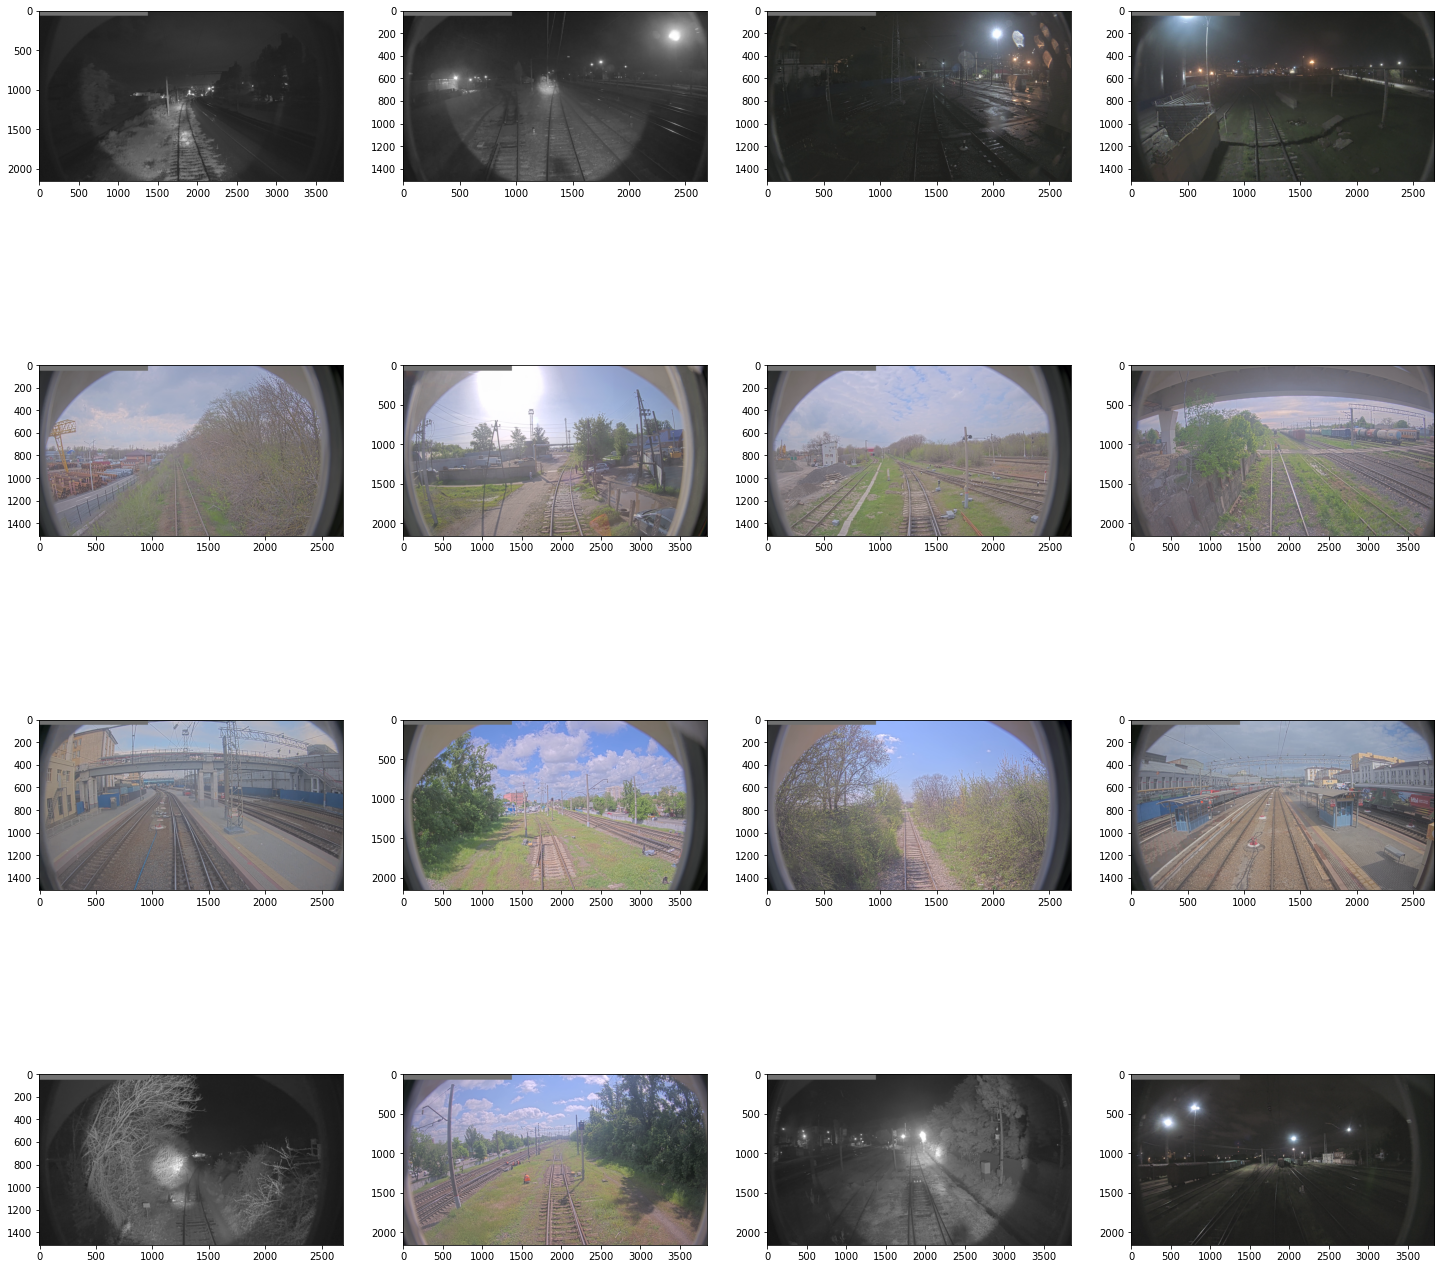

In [16]:
pic_box = plt.figure(figsize=(25,25))

for i in range(0, 16):
    pic_box.add_subplot(4,4,i+1)
    image = cv2.imread(ALL_TEST_IMAGES[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

plt.show()    

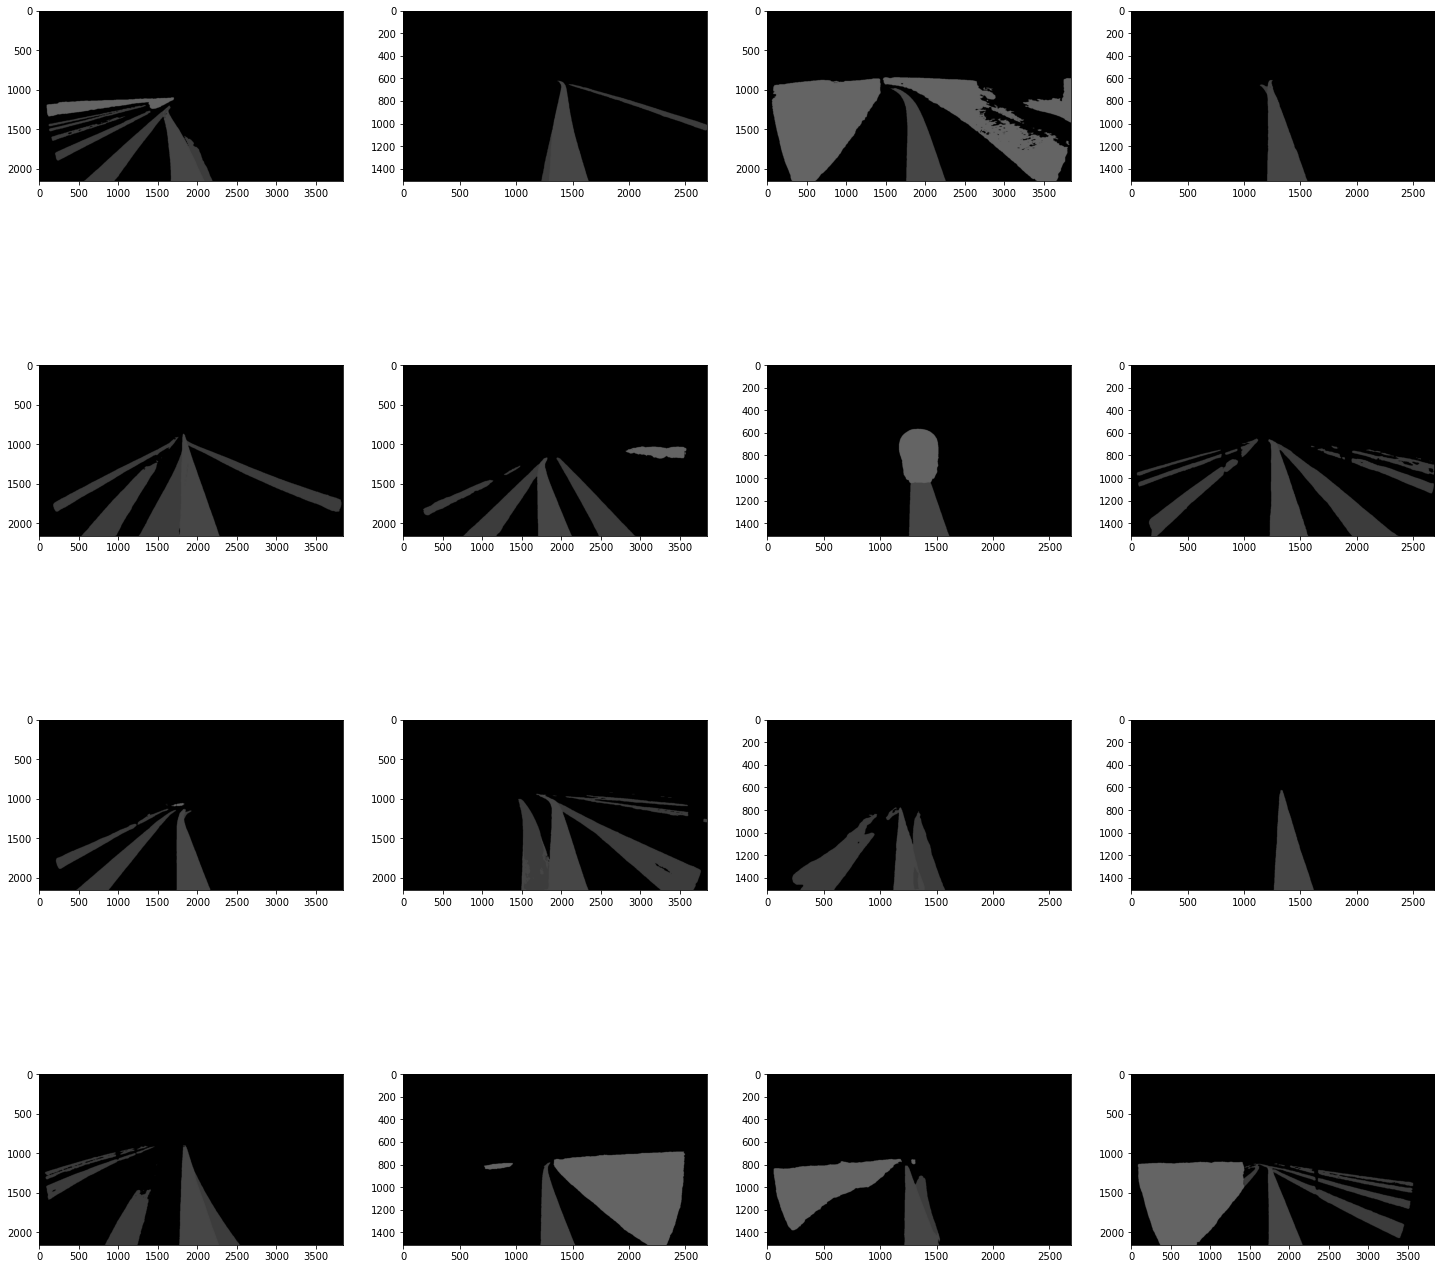

In [17]:
MASK_FINAL = ["submit_final/" + i.split("/")[-1] for i in ALL_TEST_IMAGES]

pic_box = plt.figure(figsize=(25,25))

for i in range(220, 236):
    pic_box.add_subplot(4,4,i-220+1)
    image = cv2.imread(MASK_FINAL[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image*10)

plt.show()    